In [153]:
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace

%matplotlib inline

# DB 만들기

In [2]:
pd.read_excel('quantking.xlsx', sheet_name='x').to_excel('quantking_x.xlsx', sheet_name='data')

In [67]:
fin = pd.read_excel('quantking_db.xlsx', sheet_name='fin', index_col=[0], header=[0,1])
mc = pd.read_excel('quantking_db.xlsx', sheet_name='mc', index_col=[0], header=[0])

In [72]:
fin = fin.stack()
mc = mc.T

In [75]:
fin.to_pickle('fin.pkl')
mc.to_pickle('mc.pkl')

In [76]:
fin.to_excel('fin.xlsx', sheet_name='fin')
mc.to_excel('mc.xlsx', sheet_name='mc')

# 전략 만들기

In [120]:
def 매출상위10(date):
    if type(date)==str:
        date = pd.Timestamp(date)
        
    year = date.year
    if date.month < 6:
        year -= 1

    position = fin['매출액'].xs(year, level=1).nlargest(10)
    position[:] = 1/len(position)
    return position

In [121]:
매출상위10('2015-05-31')

A005930    0.1
A005380    0.1
A096770    0.1
A005490    0.1
A066570    0.1
A015760    0.1
A009540    0.1
A000270    0.1
A000880    0.1
A036460    0.1
Name: 매출액, dtype: float64

# 백테스트

In [146]:
dates = mc.index[8:]
positions = {}
nav = {}

for i,date in enumerate(dates):
    position = 매출상위10(date)
    positions[date] = position
    
    if i==0:
        nav[date] = 1
    
    else:
        date_prev = dates[i-1]
        nav_prev = nav[date_prev]
        pos_prev = positions[date_prev]
        assets_prev = pos_prev.index
        pos_update = mc.loc[date, assets_prev]/mc.loc[date_prev, assets_prev] * pos_prev
        nav[date] = nav_prev * pos_update.sum()

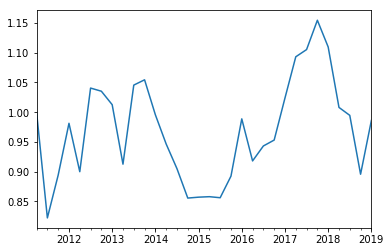

In [161]:
pd.Series(nav).plot();

In [133]:
assets = 매출상위10('2011-06-30').index; assets

Index(['A005930', 'A005380', 'A005490', 'A096770', 'A066570', 'A009540',
       'A015760', 'A000270', 'A010950', 'A036460'],
      dtype='object')

In [134]:
mc.loc['2011-09-30', assets]/mc.loc['2011-06-30', assets] * 매출상위10('2011-06-30')

A005930    0.101695
A005380    0.089030
A005490    0.079957
A096770    0.070823
A066570    0.083112
A009540    0.063360
A015760    0.074250
A000270    0.099642
A010950    0.076364
A036460    0.083920
dtype: float64

# 성과측정